In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import scipy.optimize as sco

rcParams['figure.figsize'] = 8, 6
rcParams['figure.dpi'] = 120
rcParams['axes.titlesize'] = 14
rcParams['axes.labelsize'] = 12
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['legend.fontsize'] = 12
rcParams['axes.grid'] = True
rcParams['grid.alpha'] = 0.3
rcParams['grid.color'] = "#CCCCCC"
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
plt.style.use(['dark_background', 'bmh'])
pd.set_option('display.max_column', None)

In [2]:
symbols = [
    'AAPL', # Apple
    'MSFT', # Microsoft
    'GOOGL', # Google
    'AMZN', # Amazon
    'NVDA', # Nvidia
    'NFLX', # Netflix
    'CSCO', # Cisco Systems
    'KO' # Coca-Cola
]

# Downloading historical close prices for the given symbols from 2010 to 2025
data = yf.download(symbols, start="2010-01-01", end="2025-01-01")['Close']

data.head()

[*********************100%***********************]  8 of 8 completed


Ticker,AAPL,AMZN,CSCO,GOOGL,KO,MSFT,NFLX,NVDA
Date,,,,,,,,
2010-01-04,6.447414,6.6950,16.363859,15.627782,17.949799,23.300676,7.640000,0.423923
2010-01-05,6.458559,6.7345,16.290955,15.558963,17.732668,23.308207,7.358571,0.430113
2010-01-06,6.355828,6.6125,16.184917,15.166741,17.726379,23.165167,7.617143,0.432864
2010-01-07,6.344077,6.5000,16.257816,14.813667,17.682312,22.924252,7.485714,0.424381
2010-01-08,6.386255,6.6760,16.343979,15.011149,17.355042,23.082354,7.614286,0.425298


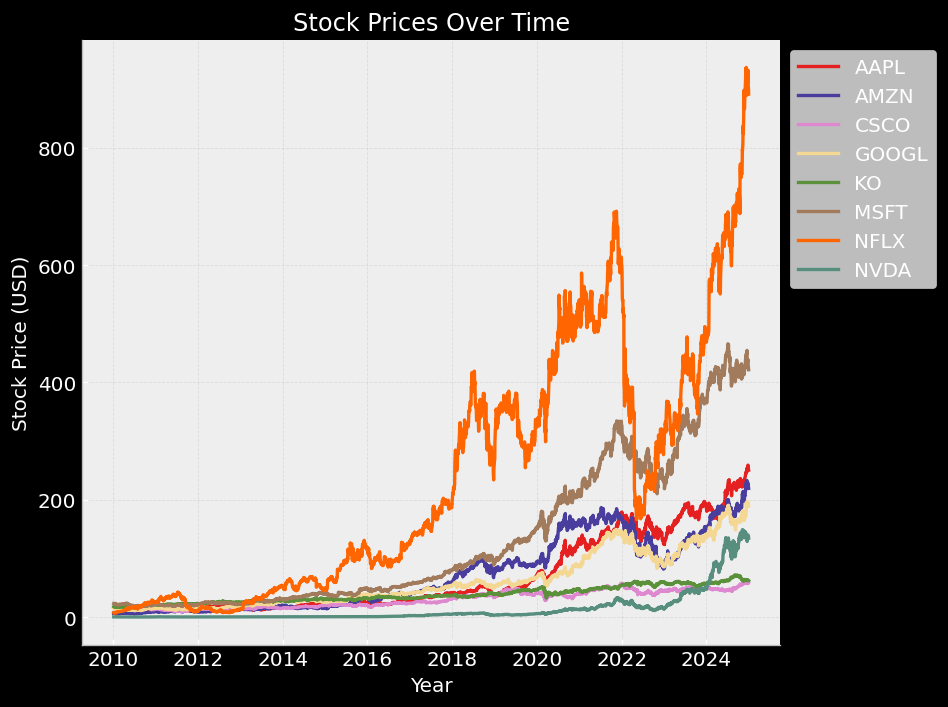

In [3]:
my_colors = ['#E52020',
             '#493D9E',
             '#DD88CF',
             '#F4D793',
             '#5B913B',
             '#A27B5C',
             '#FF6500',
             '#578E7E']

for stock, color in zip(data.columns, my_colors):
    plt.plot(data.index, data[stock], label=stock, color=color)

plt.title('Stock Prices Over Time')
plt.xlabel('Year')
plt.ylabel('Stock Price (USD)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [4]:
daily_return = data.pct_change().dropna()
mean_returns = daily_return.mean() * 252
cov_matrix = daily_return.cov() * 252
variance_returns = daily_return.var() * 252
risk_free_rate = 0.0178

# Diverse Portfolio

In [5]:
stocks_data = pd.DataFrame({
    'StockSymbol': data.columns,
    'Return': mean_returns.values,
    'Variance': variance_returns.values
})

stocks_data.sample(3)

,StockSymbol,Return,Variance
2,CSCO,0.119097,0.066867
4,KO,0.097639,0.028985
3,GOOGL,0.203860,0.074700


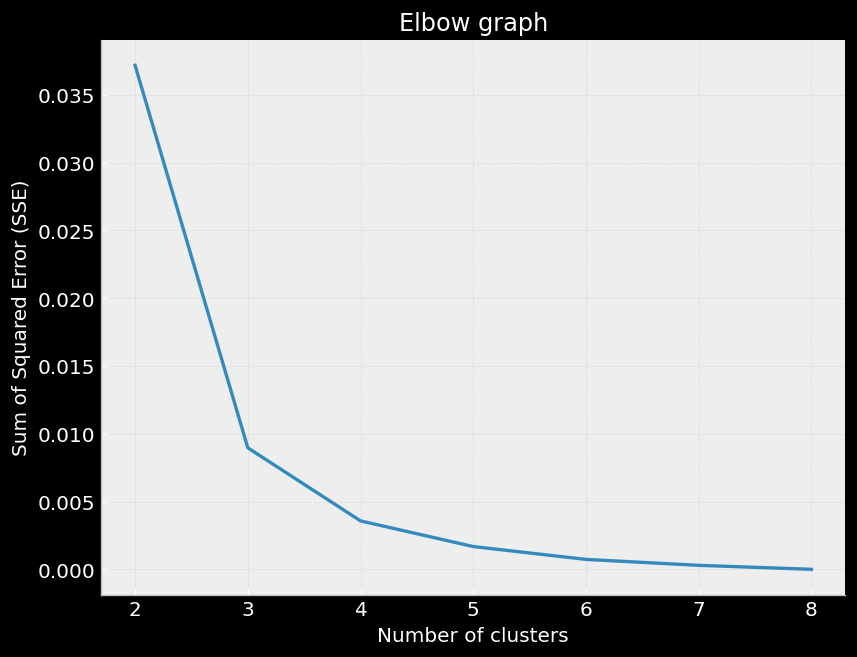

In [6]:
X = stocks_data[['Return', 'Variance']].values
inertia = []

for i in range(2, len(data.columns) + 1):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, len(data.columns) + 1), inertia)
plt.title('Elbow graph')
plt.ylabel('Sum of Squared Error (SSE)')
plt.xlabel('Number of clusters')
plt.show()

In [7]:
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10).fit(X)
labels = kmeans.labels_
stocks_data['ClusterLabel'] = labels

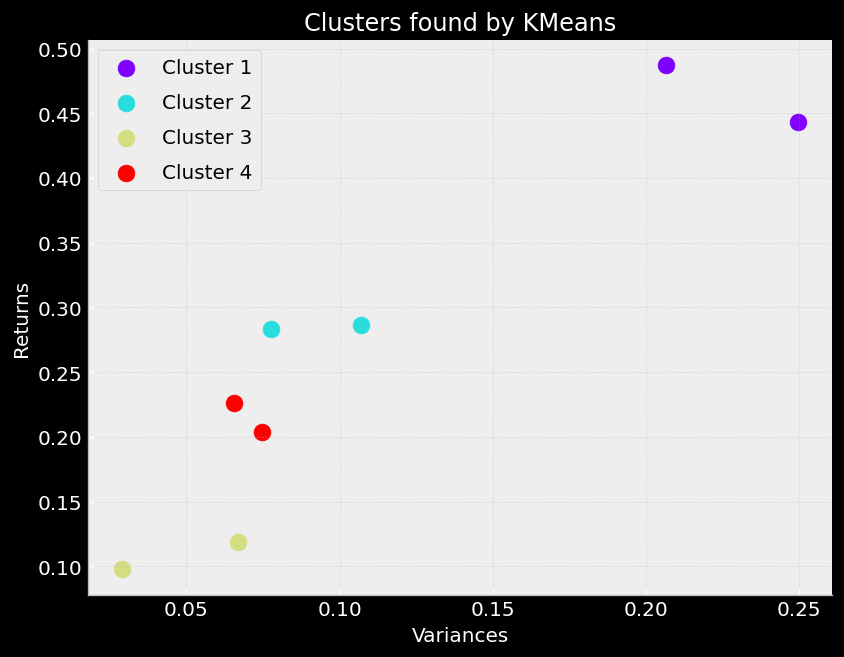

In [8]:
colors = plt.cm.rainbow(np.linspace(0, 1, 4))

for i in range(4):
    plt.scatter(X[labels == i, 1], X[labels == i, 0], color=colors[i], label=f'Cluster {i+1}', s=100)

plt.title('Clusters found by KMeans')
plt.xlabel('Variances')
plt.ylabel('Returns')
plt.legend(labelspacing=0.8, labelcolor='black')

plt.show()

In [9]:
def diverse_portfolio(stocks_data, n_stocks_per_cluster):
    portfolio = []

    for cluster in sorted(stocks_data['ClusterLabel'].unique()):
        selected_stocks = stocks_data[stocks_data['ClusterLabel'] == cluster].head(n_stocks_per_cluster)
        portfolio.append(selected_stocks[['StockSymbol', 'ClusterLabel']])

    return pd.concat(portfolio).reset_index(drop=True)

In [10]:
diverse_portfolio(stocks_data, n_stocks_per_cluster=1)

,StockSymbol,ClusterLabel
0,NFLX,0
1,AAPL,1
2,CSCO,2
3,GOOGL,3


# Beta calculation

In [11]:
market_symbol = 'SPY'

# Download market data for S&P 500
df_market = yf.download(market_symbol, start='2010-01-01', end='2025-01-01')['Close']
df_market_returns = df_market.pct_change().dropna()

[*********************100%***********************]  1 of 1 completed


In [12]:
betas = {}

for stock in symbols:
    df_stock_returns = data[stock].pct_change().dropna()

    aligned_stock, aligned_market = df_stock_returns.align(df_market_returns, join='inner')

    if len(aligned_stock) != len(aligned_market):
        print(f"Warning: Data mismatch for {stock}. Stock data length: {len(aligned_stock)}, Market data length: {len(aligned_market)}")
        continue

    stock_returns = aligned_stock.values.reshape(-1, 1)
    market_returns = aligned_market.values.reshape(-1, 1)

    covariance_matrix = np.cov(stock_returns.T, market_returns.T)
    beta = covariance_matrix[0, 1] / covariance_matrix[1, 1]
    betas[stock] = beta

In [13]:
print("Stock Betas vs Market (SPDR S&P 500 ETF):")
for stock, beta_value in betas.items():
    print(f"{stock}: {beta_value:.4f}")

Stock Betas vs Market (SPDR S&P 500 ETF):
AAPL: 1.1180
MSFT: 1.1318
GOOGL: 1.1029
AMZN: 1.1493
NVDA: 1.6572
NFLX: 1.1143
CSCO: 1.0031
KO: 0.5969


# Portfolio Optimization

In [14]:
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(weights * mean_returns)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return volatility, returns

In [15]:
def monte_carlo_simulation(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3, num_portfolios))
    weights_list = []

    for _ in range(num_portfolios):
        weights = np.random.dirichlet(np.ones(len(mean_returns)), size=1)[0]
        weights_list.append(weights)

        volatility, expected_return = portfolio_performance(weights, mean_returns, cov_matrix)
        sharpe_ratio = (expected_return - risk_free_rate) / volatility

        results[0, _] = volatility
        results[1, _] = expected_return
        results[2, _] = sharpe_ratio

    return results, weights_list

In [16]:
num_portfolios = 50000
results, weights_list = monte_carlo_simulation(num_portfolios, mean_returns, cov_matrix, risk_free_rate)

In [17]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [18]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

In [19]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [20]:
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = monte_carlo_simulation(num_portfolios,mean_returns, cov_matrix, risk_free_rate)

    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x, index=data.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x, index=data.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T

    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)

    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.85)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe-Ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum Volatility')

    target = np.linspace(rp_min, 0.32, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='Efficient Frontier')
    plt.title('Optimized Portfolio Allocation: Max Sharpe Ratio and Min Volatility on the Efficient Frontier')
    plt.xlabel('Volatility')
    plt.ylabel('Returns')
    plt.legend(labelspacing=0.8, labelcolor='blue')

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.34
Annualised Volatility: 0.26


Ticker       AAPL  AMZN  CSCO  GOOGL     KO  MSFT   NFLX   NVDA
allocation  33.07  7.28   0.0    0.0  13.31   0.0  19.32  27.02
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.14
Annualised Volatility: 0.16


Ticker      AAPL  AMZN  CSCO  GOOGL     KO  MSFT  NFLX  NVDA
allocation  5.74  3.99  8.96   5.69  70.49  2.68  2.45   0.0


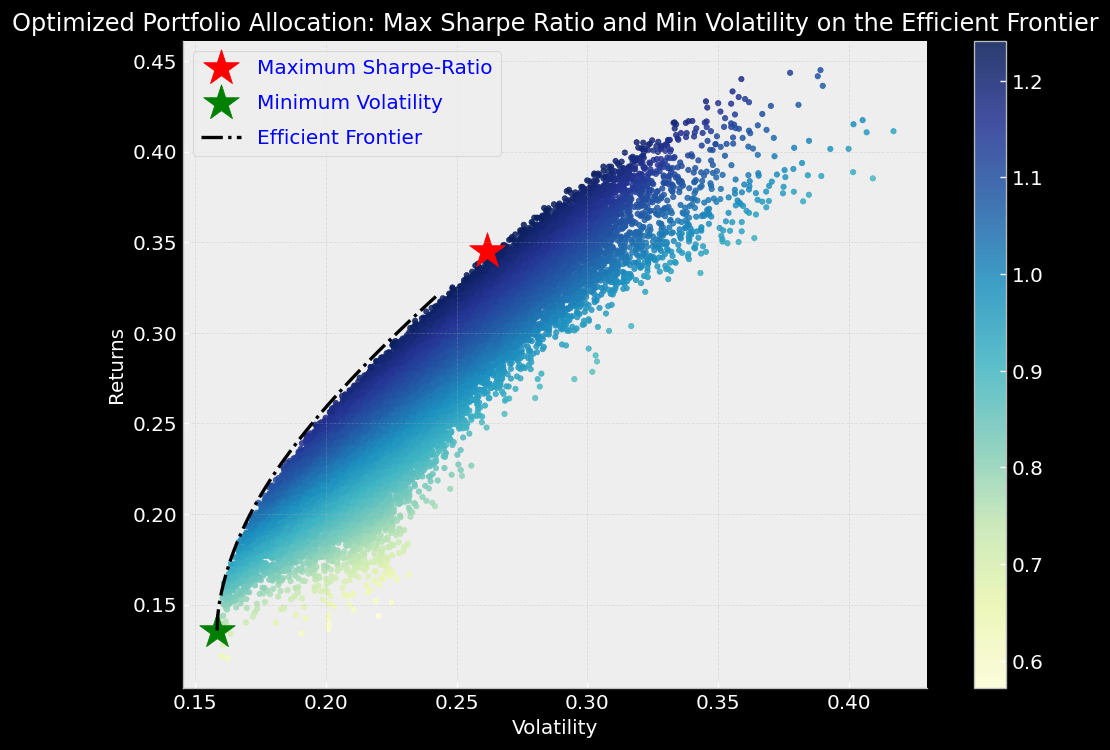

In [21]:
display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)